# Project 3: Machine Learning C'25
### This is a standard image classification task designed to help everyone get fimiliar with the entire preocess of building up a machine learning project and understanding the key concepts and functions of its different components.

We will use PyTorch for the whole project. The Program Template is given, both py version and ipynb version.

# Import Packages

In [41]:
import os
import random

# data part
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split, Subset

# model part
import torch
import torch.nn as nn
import torch.nn.functional as F

# training & testing part
from tqdm.auto import tqdm

# evaluation & visualization part
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Get Dataset
## FER2013 Dataset: [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge)
-

### For example code, we provide you how to load the training data into the dataloader which can be used to fit the model. Don't forget to download the data from Canvas and unzip it before you run the template.

### Do check the file address in case you don't keep the file structure which works for the template.
-

After getting the dataset, can use dataset.classes to get the class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'].

In [ ]:
# This is a command line code for Jupyter Notebook to unzip file
# Please change the first address to the zip file path
# The second path is for the images folder
!unzip -q fer_2013_train.zip -d ./

replace ./__MACOSX/._fer_2013_train? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./fer_2013_train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/fer_2013_train/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/fer_2013_train/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/fer_2013_train/train/._happy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./fer_2013_train/train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/fer_2013_train/train/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace ./__MACOSX/fer_2013_train/train/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/fer_2013_train/train/._sad? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/fer_2013_train/train/._fear? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/fer_2013_train/train/._surprise? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ./__MACOSX/

In [42]:
import os
print(os.listdir())

['.config', 'drive', 'fer_2013_train.zip', 'fer_2013_test.zip', 'fer_2013_train', 'fer_2013_test', '__MACOSX', 'model_best.pth', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


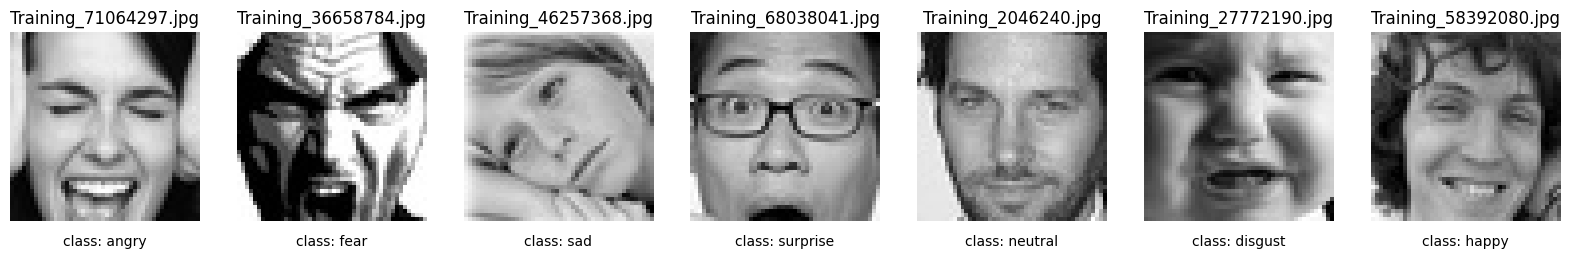

In [43]:
## If you want to show some image samples

# Image dir
image_dir = "./fer_2013_train/train"

# Images from all classes
class_folders = [folder for folder in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, folder))]

# Random pick 1 image from every class
num_images = len(class_folders)
selected_images = []

for class_name in class_folders:
  class_path = os.path.join(image_dir, class_name)
  image_files = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
  if image_files:
    selected_image = random.choice(image_files)
    selected_images.append((os.path.join(class_path, selected_image), class_name))

# Images show
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

for i, (img_path, img_class) in enumerate(selected_images):
    image = Image.open(img_path)
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")
    # File name
    axes[i].set_title(os.path.basename(img_path))
    # File size
    pos = axes[i].get_position()
    fig.text(pos.x0 + pos.width / 2, pos.y0 - 0.05, f"class: {img_class}",
             fontsize=10, ha="center")
plt.show()

# Transforms (*)
## For this part you need to try different transforms to get better classification results.
-
### Torchvision provides lots of image preprocessing utilities, we can use them as ways to get data augmentation.
### As you can see the samples above, the images have different sizes. We can use simple transforms to resize the PIL image and turn it into Tensor.
### Also, data augmentation can be done with transforms. You can use it to produce a variety of images, including rotation, scaling, flipping, color adjustments, and more.
-

Please check PyTorch official website for transforms details: [link](https://pytorch.org/vision/0.9/transforms.html)

In [44]:
# Usually we don't need augmentations in testing and also validation
# But we still need to resize the PIL image and transform it into Tensor
test_transforms = transforms.Compose([
    # Turn the image into grayscale (1 channel)
    transforms.Grayscale(num_output_channels=1),
    # Resize the image into a fixed shape (example for height = width = 128)
    # You may need to try different image sizes to find the size fits your model best
    transforms.Resize((128, 128)),

    transforms.RandomRotation(15),  # Rotate images by ±15 degrees
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random zoom-in
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomSolarize(threshold=192, p=1),


    transforms.ToTensor(),
    # If you use normalization for the train_data, also need to normalize the test_data
])


# Use train_transforms to implement data augmentation
train_transforms = transforms.Compose([
    # Turn the image into grayscale (1 channel)
    transforms.Grayscale(num_output_channels=1),
    # Resize the image into a fixed shape (example for height = width = 128)
    # You may need to try different image sizes to find the size fits your model best
    transforms.Resize((128, 128)),

    ###################################
    ###################################
    # You may do some transforms here #
    ###################################
    ###################################


    # ToTensor() should be the last one of the transforms
    transforms.ToTensor(),
])


### Data Augmentation/Transforms Implementation Examples

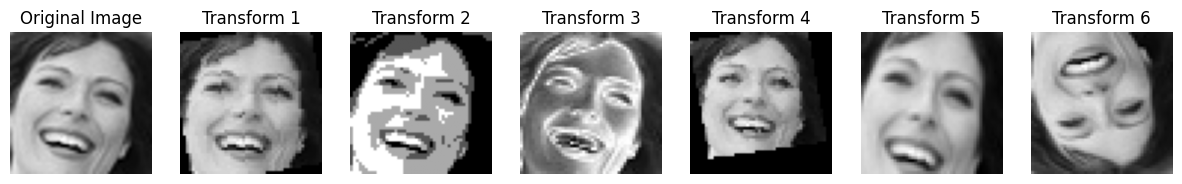

# Model (*)
## For this part you need to try different model structures to get better classification results. You can try different layer types, different number of layers, different activate functions, and etc.
-
### The default classification accuracy is around 0.3 which is better than the random guess, but looking at the training process, the model basically didn't learn anything.

In [45]:
class Classifier(nn.Module):
    def __init__(self, num_classes=7):
        super(Classifier, self).__init__()

        # You may have some your own layers here

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Additional Conv Layer
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        self.dropout = nn.Dropout(0.3)




        # Feel free to experiment with different layer combinations.

        self.layer_flatten = nn.Flatten()
        # For Linear output only, can use CrossEntropyLoss() for the loss (automatically apply Softmax)
        #self.fc_layer_for_output = nn.Linear(128 * 128, num_classes)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # First FC layer
        self.fc2 = nn.Linear(512, 128)  # Second FC layer
        self.fc3 = nn.Linear(128, num_classes)  # Output layer (num_classes = 7 for emotions)
        # If you are using Linear + Sigmoid as the output layer, then BCELoss() can be used to get the loss
        # To know more about criterion, please check PyTorch official site




    # forward() defines how the input data flows through the layers of the model during the forward pass
    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.layer_flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        #output = self.fc_layer_for_output(x)
        return x

# Configurations (*)
## Here is the part you can "control" the training process by setting your own hyperparameters, which might affect your model performance. Main hyperparameters include the data batch size, number of training epochs, the loss function, optimizer and etc.
-
### Please try sets of experiments with different combinations of hyperparameters to determine which goes best with your model.

In [46]:
# Check whether GPU is availbale and set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Initialize the model, and don't forget to put it on the device
model = Classifier().to(device)

###########################################################################################
###########################################################################################
# You can try differnet configurations below for training the model to get better results #
###########################################################################################
###########################################################################################

# The number of batch size
batch_size = 128

# The number of training epochs
n_epochs = 30

# Set up the criterion, we usually use cross-entropy as the measurement of classification performance
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you can try different hyperparameters or different types of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Using device: cuda


# Dataloader
## This is how PyTorch help you to load the data as a dataloader.
-
### For the template, we use the ImageFolder provided by torchvision.datasets to read the data with the folder annotations. YOu can also write you own data class to read the images and labels.
### For the template, we also use random_split from torch.utils.data to get the training and validation data. You can also try other data split methods such as train_test_split from sklearn and etc. The training and validation ratio can also be adjusted.
### Do not use the train_transforms for the validation data, since you may have some data augmentation operations for training data.
-

For more infomation about data and dataloader, please refer to the PyTorch website: [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#datasets-dataloaders)

In [47]:
# Construct train datasets
# The argument "loader" tells how torchvision reads the data.
train_dir = "./fer_2013_train/train"

# We use ImageFolder to read the images and set the annotations for each image
# Do not use train_transforms for this step, since the validation data should not have data augmantation
full_train_dataset = ImageFolder(train_dir)

# Aligned with official dataset
original_class_to_idx = full_train_dataset.class_to_idx
desired_class_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

new_class_to_idx = {cls_name: i for i, cls_name in enumerate(desired_class_order)}
full_train_dataset.class_to_idx = new_class_to_idx

full_train_dataset.samples = [
    (img_path, new_class_to_idx[original_cls_name])
    for img_path, original_cls_idx in full_train_dataset.samples
    for original_cls_name, idx in original_class_to_idx.items() if idx == original_cls_idx
]

# Construct valid datasets
# You can also use other methods like train_test_split() to get the validation set

# 80% training，20% validation
train_ratio = 0.8
train_size = int(train_ratio * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# random_split() by PyTorch
train_indices, val_indices = random_split(range(len(full_train_dataset)), [train_size, val_size])

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Set the transforms separately for training and validation data
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples: 22932, Validation samples: 5734


In [48]:
# You are encouraged to show some train and validation data and label to know better about your data.

# Training Process
## Show the whole training process including the validation part, and save model at the last step. Basically, you don't need to change anything for this part. However, you should know clearly about the whole process about how to train your model.
-

For more infomation about training a model, please refer to PyTorch website: [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#training-with-pytorch)



In [49]:
# Record the best validation acc to save the best model
best_acc = 0

train_acc_history = []
valid_acc_history = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        # Automatically invokes the forward() method in your model class.
        # Make sure your model has a properly defined forward() method to handle data flow.
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_acc_history.append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    valid_acc_history.append(valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        save_path = "model_best.pth"
        print(f"Best model found at epoch {epoch+1}, saving model")
        torch.save(model.state_dict(), save_path)
        best_acc = valid_acc

  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 001/030 ] loss = 1.79075, acc = 0.25569


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 001/030 ] loss = 1.74095, acc = 0.28713
Best model found at epoch 1, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 002/030 ] loss = 1.72249, acc = 0.30372


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 002/030 ] loss = 1.66586, acc = 0.32689
Best model found at epoch 2, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 003/030 ] loss = 1.66293, acc = 0.33332


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 003/030 ] loss = 1.68012, acc = 0.33150
Best model found at epoch 3, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 004/030 ] loss = 1.60085, acc = 0.36980


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 004/030 ] loss = 1.55085, acc = 0.38937
Best model found at epoch 4, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 005/030 ] loss = 1.55603, acc = 0.38632


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 005/030 ] loss = 1.54470, acc = 0.39913
Best model found at epoch 5, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 006/030 ] loss = 1.52747, acc = 0.40798


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 006/030 ] loss = 1.47922, acc = 0.42477
Best model found at epoch 6, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 007/030 ] loss = 1.48668, acc = 0.42312


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 007/030 ] loss = 1.44187, acc = 0.43958
Best model found at epoch 7, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 008/030 ] loss = 1.45997, acc = 0.43776


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 008/030 ] loss = 1.42379, acc = 0.45304
Best model found at epoch 8, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 009/030 ] loss = 1.42898, acc = 0.44839


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 009/030 ] loss = 1.40867, acc = 0.46106
Best model found at epoch 9, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 010/030 ] loss = 1.41409, acc = 0.45297


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 010/030 ] loss = 1.38247, acc = 0.46432
Best model found at epoch 10, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 011/030 ] loss = 1.39427, acc = 0.45977


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 011/030 ] loss = 1.37851, acc = 0.46198


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 012/030 ] loss = 1.36602, acc = 0.47296


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 012/030 ] loss = 1.33320, acc = 0.49086
Best model found at epoch 12, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 013/030 ] loss = 1.35873, acc = 0.47423


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 013/030 ] loss = 1.33358, acc = 0.48815


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 014/030 ] loss = 1.33496, acc = 0.48459


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 014/030 ] loss = 1.32397, acc = 0.49050


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 015/030 ] loss = 1.33039, acc = 0.48913


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 015/030 ] loss = 1.28494, acc = 0.51045
Best model found at epoch 15, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 016/030 ] loss = 1.31771, acc = 0.49664


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 016/030 ] loss = 1.31357, acc = 0.49275


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 017/030 ] loss = 1.30455, acc = 0.50164


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 017/030 ] loss = 1.29846, acc = 0.50469


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 018/030 ] loss = 1.29246, acc = 0.50105


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 018/030 ] loss = 1.27500, acc = 0.51120
Best model found at epoch 18, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 019/030 ] loss = 1.28805, acc = 0.50819


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 019/030 ] loss = 1.25875, acc = 0.51871
Best model found at epoch 19, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 020/030 ] loss = 1.26361, acc = 0.51680


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 020/030 ] loss = 1.25574, acc = 0.51063


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 021/030 ] loss = 1.26942, acc = 0.51099


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 021/030 ] loss = 1.27457, acc = 0.50985


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 022/030 ] loss = 1.25315, acc = 0.52245


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 022/030 ] loss = 1.24891, acc = 0.51546


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 023/030 ] loss = 1.24508, acc = 0.52519


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 023/030 ] loss = 1.24279, acc = 0.52490
Best model found at epoch 23, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 024/030 ] loss = 1.24049, acc = 0.52639


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 024/030 ] loss = 1.22930, acc = 0.52574
Best model found at epoch 24, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 025/030 ] loss = 1.23572, acc = 0.52807


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 025/030 ] loss = 1.23583, acc = 0.52536


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 026/030 ] loss = 1.22820, acc = 0.52943


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 026/030 ] loss = 1.23367, acc = 0.52965
Best model found at epoch 26, saving model


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 027/030 ] loss = 1.21635, acc = 0.53219


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 027/030 ] loss = 1.23672, acc = 0.52561


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 028/030 ] loss = 1.21591, acc = 0.53502


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 028/030 ] loss = 1.24524, acc = 0.52855


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 029/030 ] loss = 1.20651, acc = 0.53892


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 029/030 ] loss = 1.25688, acc = 0.52696


  0%|          | 0/180 [00:00<?, ?it/s]

[ Train | 030/030 ] loss = 1.20144, acc = 0.54637


  0%|          | 0/45 [00:00<?, ?it/s]

[ Valid | 030/030 ] loss = 1.19207, acc = 0.54206
Best model found at epoch 30, saving model


# Dataloader for Test
## We've used dataloader at the training phase, for testing part, the only difference is that we don't need to apply any data augmentation technique except for resize and ToTensor.
-
### We keep part of the test data and we’ll run your best performing model to determine its accuracy on our own test set.



In [50]:
# This is a command line code for Jupyter Notebook to unzip file
# Please change the first address to the zip file path
# The second path is for the images folder
!unzip -q fer_2013_test.zip -d ./

replace ./fer_2013_test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [51]:
# Construct test datasets
# The argument "loader" tells how torchvision reads the data.
test_dir = "./fer_2013_test/test"

# We use ImageFolder to read the images and set the annotations for each image
test_dataset = ImageFolder(test_dir, transform=test_transforms)

# Aligned with official dataset
original_class_to_idx = test_dataset.class_to_idx
desired_class_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

new_class_to_idx = {cls_name: i for i, cls_name in enumerate(desired_class_order)}
label_map = {i: cls_name for i, cls_name in enumerate(desired_class_order)}

test_dataset.class_to_idx = new_class_to_idx

test_dataset.samples = [
    (img_path, new_class_to_idx[original_cls_name])
    for img_path, original_cls_idx in test_dataset.samples
    for original_cls_name, idx in original_class_to_idx.items() if idx == original_cls_idx
]

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Testing Process
## This is the testing phase for verifying your model's performance. We need to load the best model you saved during the training phase with trained parameters. After we get the predictions by the model and true labels, we can use them to do the evaluations.
-

For more infomation about testing a model, please refer to PyTorch website: [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#training-with-pytorch)

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

save_path = "model_best.pth"
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(save_path))

model_best.eval()
predictions = []
true_labels = []

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

label_map = {i: cls_name for i, cls_name in enumerate(desired_class_order)}


'''
with torch.no_grad():
    for data, labels in tqdm(test_loader):
        data, labels = data.to(device), labels.to(device)





        model_output = model_best(data.to(device))
        predicted_label = torch.argmax(model_output, dim=1).cpu().numpy()

        predictions.extend(predicted_label)
        true_labels.extend(labels)

        for i in range(len(labels)):
            if predicted_label[i] != labels[i].cpu().numpy():  # If misclassified
                misclassified_images.append(data[i].cpu())  # Store image
                misclassified_labels.append(labels[i].cpu().numpy())  # True label
                misclassified_preds.append(predicted_label[i])  # Predicted label

'''
with torch.no_grad():
    for data, labels in tqdm(test_loader):
        data, labels = data.to(device), labels.to(device)

        model_output = model_best(data)
        predicted_label = torch.argmax(model_output, dim=1).cpu().numpy()

        predictions.extend(predicted_label)
        true_labels.extend(labels.cpu().numpy())  # Move labels to CPU before storing

        # 🔹 Convert numbers to words when storing misclassified images
        for i in range(len(labels)):
            true_label = labels[i].cpu().numpy()
            pred_label = predicted_label[i]

            if true_label != pred_label:  # If misclassified
                misclassified_images.append(data[i].cpu())  # Store image
                misclassified_labels.append(label_map[int(true_label)])  # Convert to emotion name
                misclassified_preds.append(label_map[pred_label])


<ipython-input-52-4e3146b268f0>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best.load_state_dict(torch.load(save_path))


  0%|          | 0/28 [00:00<?, ?it/s]

# Evaluation & Visualizations (*)

### Training & Validation Performance Plot

The plot should show how training accuracy and validation accuracy change over time during training. Graph number of training epochs (x-axis) versus training set and validation set accuracy (y-axis). Hence, your plot should contain two curves.

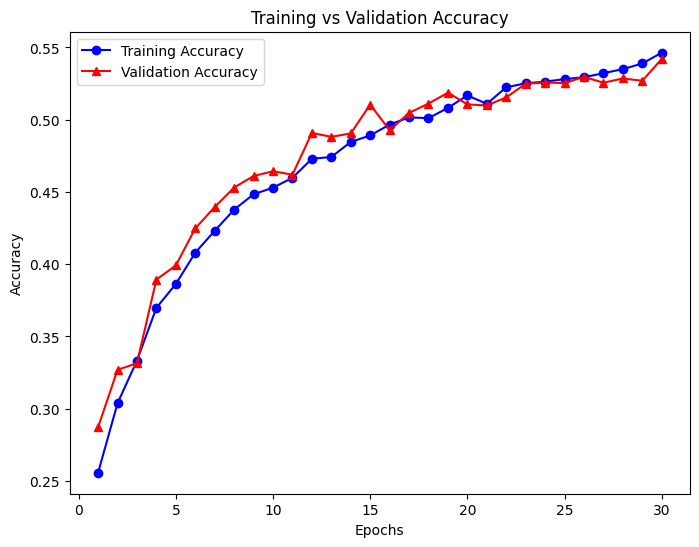

In [53]:
# Your code to implement
plt.figure(figsize=(8,6))
plt.plot(range(1, n_epochs+1), torch.tensor(train_acc_history).cpu().numpy(), 'bo-', label='Training Accuracy')
plt.plot(range(1, n_epochs+1), torch.tensor(valid_acc_history).cpu().numpy(), 'r^-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

### Confusion Matrix
The matrix should be a 7-by-7 grid showing which categories of images were classified. Use your confusion matrix to additionally report precision and recall for each of the 7 classes, as well as the overall accuracy of your model.  

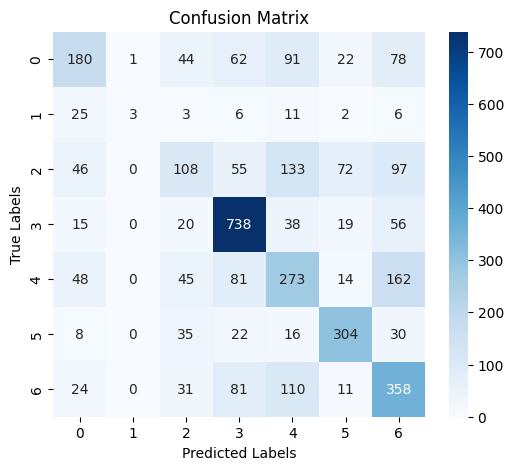

In [54]:
import sklearn
# Your code to implement
cm = sklearn.metrics.confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [55]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predictions, target_names=desired_class_order)
print(report)

              precision    recall  f1-score   support

       angry       0.52      0.38      0.44       478
     disgust       0.75      0.05      0.10        56
        fear       0.38      0.21      0.27       511
       happy       0.71      0.83      0.76       886
         sad       0.41      0.44      0.42       623
    surprise       0.68      0.73      0.71       415
     neutral       0.45      0.58      0.51       615

    accuracy                           0.55      3584
   macro avg       0.56      0.46      0.46      3584
weighted avg       0.54      0.55      0.53      3584



In [ ]:
print(test_loader.dataset.classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Misclassified Image Visualization
Include 3 visualizations of images that were misclassified by your best-performing model. You will have to create or use a program that get the misclassified images and translate it into a grayscale image and show.



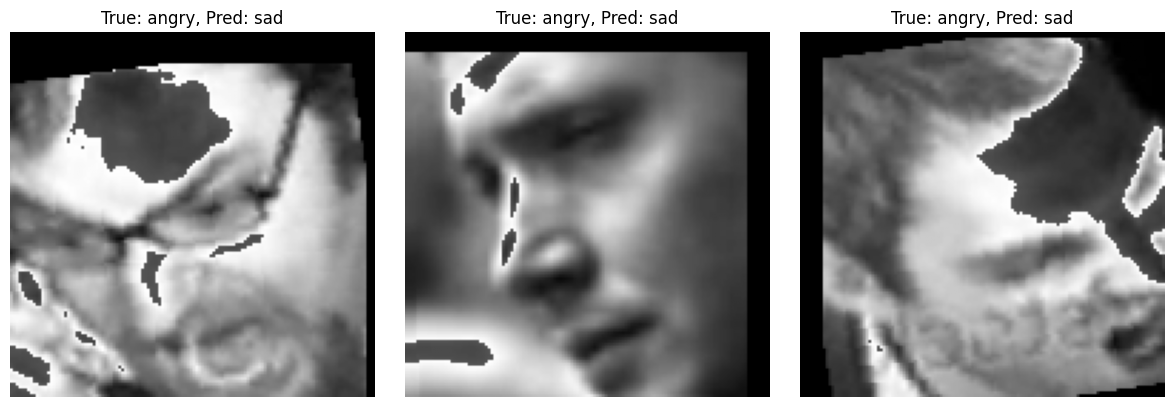

In [56]:
# Your code to implement
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):  # Show 3 misclassified images
    img = misclassified_images[i].squeeze(0).numpy()  # Convert to NumPy
    axes[i].imshow(img, cmap="gray")  # Show grayscale image
    axes[i].set_title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()